In [352]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve,classification_report,auc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

In [353]:
# Load the Iris dataset from CSV file
df = pd.read_csv('iris.csv')

df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [354]:
# Separate features (X) and target (y)
X = df.iloc[:, :-1]  # all columns except the last one
y = df.iloc[:, -1]  # the last column (species)

print(X.head())
print("\n",X.shape)
print("\n",y.head())
print("\n",y.shape)
print("\n",y.value_counts())

# change the values to mumpy
X = df.iloc[:, :-1].values  # change x to numpy
y = df.iloc[:, -1].values   # change y to numpy

   sepal_length  sepal_width  petal_length  petal_width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2

 (150, 4)

 0    Iris-setosa
1    Iris-setosa
2    Iris-setosa
3    Iris-setosa
4    Iris-setosa
Name: species, dtype: object

 (150,)

 Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: species, dtype: int64


In [355]:
from sklearn.preprocessing import LabelEncoder

# Convert target species (y) to numeric labels
label_encoder = LabelEncoder()
# print(y)
y = label_encoder.fit_transform(y)
# print("\n",y)



In [356]:
# Normalize the features (X)
scaler = StandardScaler()
# print(X)
X = scaler.fit_transform(X)
# print("\n",X)

In [357]:
# Split the dataset into training and testing sets 
# 80% train, 20% test with respect to values of (y) with same ratio 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# y_train = torch.tensor(y_train, dtype=torch.long)
# torch.bincount(y_train)

In [358]:
# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create a TensorDataset for PyTorch DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# DataLoader to load data in batches
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [359]:
# Define the neural network model
class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, 16)  # 4 input features, 16 hidden units
        self.fc2 = nn.Linear(16, 32) # 32 hidden units
        self.fc3 = nn.Linear(32, 3)  # 3 output units (3 classes)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # No activation here as CrossEntropyLoss handles it
        return x


In [360]:
# Initialize the model, loss function, and optimizer
model = IrisNet()
criterion = nn.CrossEntropyLoss()  # Loss function for multiclass classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

In [361]:
# Lists to store loss values
train_losses = []
val_losses = []

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    # Training loop
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        running_loss += loss.item()

    # Average training loss for the epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loss calculation
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

    # Average validation loss for the epoch
    avg_val_loss = val_running_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    if (epoch+1) %10 ==0 or epoch==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')


Epoch [1/100], Training Loss: 1.1054, Validation Loss: 1.0795
Epoch [10/100], Training Loss: 0.6031, Validation Loss: 0.5921
Epoch [20/100], Training Loss: 0.3209, Validation Loss: 0.3630
Epoch [30/100], Training Loss: 0.2105, Validation Loss: 0.2672
Epoch [40/100], Training Loss: 0.1484, Validation Loss: 0.1878
Epoch [50/100], Training Loss: 0.1165, Validation Loss: 0.1346
Epoch [60/100], Training Loss: 0.0811, Validation Loss: 0.1046
Epoch [70/100], Training Loss: 0.0662, Validation Loss: 0.0877
Epoch [80/100], Training Loss: 0.0611, Validation Loss: 0.0774
Epoch [90/100], Training Loss: 0.0537, Validation Loss: 0.0712
Epoch [100/100], Training Loss: 0.0456, Validation Loss: 0.0674


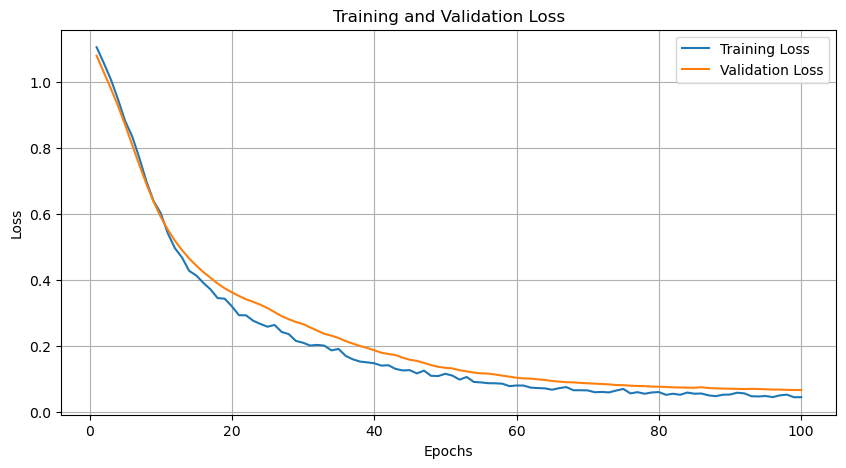

In [362]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.savefig('training_validation_loss.png', format='png')
plt.show()  # Show the plot


In [363]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    _, predicted_classes = torch.max(y_pred, 1)  # Get the predicted class indices
    predicted_probs = torch.softmax(y_pred, dim=1)  # Get probabilities for ROC curve


In [364]:
# Accuracy
accuracy = accuracy_score(y_test.numpy(), predicted_classes.numpy())
print(f'Accuracy: {accuracy:.4f}')
print("\n")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test.numpy(), predicted_classes.numpy())
print('Confusion Matrix:')
print(conf_matrix)
print("\n")

# Calculate precision, recall, F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_test.numpy(), predicted_classes.numpy(), average='macro')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
print("\n")

# Classification Report (Precision, Recall, F1-Score)
class_report = classification_report(y_test.numpy(), predicted_classes.numpy(), target_names=label_encoder.classes_)
print('Classification Report:')
print(class_report)

Accuracy: 0.9667


Confusion Matrix:
[[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]


Precision: 0.9697, Recall: 0.9667, F1-Score: 0.9666


Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      0.90      0.95        10
 Iris-virginica       0.91      1.00      0.95        10

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



ROC-AUC (One-vs-Rest): 0.9750


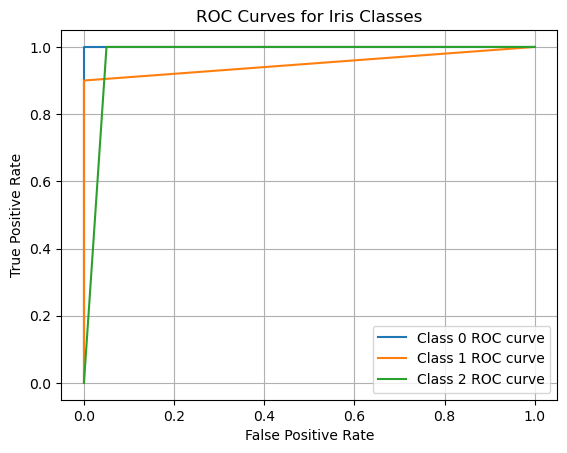

In [365]:

# ROC-AUC curve (One-vs-Rest for multiclass)
# Binarize the true and predicted labels for ROC curve
y_true_binarized = label_binarize(y_test.numpy(), classes=[0, 1, 2])
y_pred_binarized = label_binarize(predicted_classes.numpy(), classes=[0, 1, 2])

# Calculate the ROC-AUC score
roc_auc_ovr = roc_auc_score(y_true_binarized, y_pred_binarized, average='macro', multi_class='ovr')
print(f"ROC-AUC (One-vs-Rest): {roc_auc_ovr:.4f}")

# Plot ROC curves for each class
n_classes = y_true_binarized.shape[1]
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_binarized[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} ROC curve')

# Plot settings
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Iris Classes')
plt.legend()
plt.grid()
plt.savefig('ROC.png', format='png')
plt.show()